# Exploring ATAC-seq signal across Endothelial cell types

This workbook uses ATAC-seq from LSECs (Cebola lab), ECFC and HUVECs (Randi lab) and LEC (Birdsey lab).

Read in all CREs in order to count reads in peaks and normalize across datasets.

Use LSEC CREs but add any CREs from HDLEC, HUVEC or ECFC which are missing (as merged peaks):

```bash
LSECcres='/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap/LSEC_CREs.bed'
LECcres='/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap/LEC_CREs.bed'
HUVECcres='/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap/H-replicated-peaks-new.bed'
ECFCcres='/cd/CB-replicated-peaks-new.bed'
TV_ERG_CREs='/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/ECs_ATAC/ERG_CREs.bed'

module load anaconda3/personal
source activate ATAC

cat ${LSECcres} ${LECcres} ${HUVECcres} ${ECFCcres} ${TV_ERG_CREs} | cut -f 1-3 | sort -k 1V,1 -k 2,2n | bedtools merge -i - > EC_CREs_merged_with_TV.bed
```

You will create a conda environment from the `diffbind.yml` file I have saved in the shared `cebola_lab_general` folder. The commented out commands below are for reference how I created the environment:
```bash 
#conda create -n diffbind mamba bioconda::bioconductor-diffbind bioconductor-complexheatmap
#source activate diffbind
#mamba install -c conda-forge r-tidyverse r-ggplot2 r-irkernel
#mamba install -c bioconda bioconductor-genomicranges bioconductor-annotationdbi bioconductor-org.hs.eg.db bioconductor-edger
#mamba install jupyter_client r-gridextra
```# Open R
R
# Install preprocessCore and disable threading
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("preprocessCore", configure.args="--disable-threading")
Update all packages
install.packages('gplots')

Run on the command line:
```bash
#module load anaconda3/personal
#conda env create -f /rds/general/project/cebola_lab_general/live/conda_envs/diffbind.yml
#source activate diffbind

```

To make the conda environment compatible with your VSCode, run:
```R
IRkernel::installspec(user = TRUE)
IRkernel::installspec(name = 'r-diffbind', displayname = 'R 4.3.3 (r-diffbind)')
quit()
```

```bash
#mamba install r-pheatmap
#conda env export > /rds/general/project/cebola_lab_general/live/conda_envs/diffbind.yml
```

In [1]:
# Set to your working directory and load libraries
setwd('/rds/general/user/tv722/projects/erg_lymphangiogenesis_project/live/heatmap')

In [2]:
#BiocManager::install("preprocessCore", configure.args="--disable-threading", force = TRUE)
#BiocManager::install("limma")
library(DiffBind)
library(tidyverse)
library(ComplexHeatmap)
library(ggplot2)
library(GenomicRanges)
library(gridExtra)
library(AnnotationDbi)
library(org.Hs.eg.db)
library(pheatmap)
library(preprocessCore)
library(gplots)
library(dplyr)
library(limma)
library(RColorBrewer)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loa

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks Biobase::combine(), BiocGenerics::combine()
✖ dplyr::count()        masks matrixStats::count()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::lag()          masks stats::lag()
✖ ggplot2::Position()   masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()       masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()       masks S4Vectors::rename()


Note, to see the manual for a command, type: `?makeGRangesFromDataFrame`

In [3]:
# Read the peaks into R and convert to a GRanges object
peaks <- read.table('EC_CREs_merged.bed')
colnames(peaks) <- c('chr','start','end')
peaks <- makeGRangesFromDataFrame(peaks)

You should have edited the `DiffBind_sampleSheet.txt` to contain the paths to the bam files (currently the paths are for directories you cannot access).

In [ ]:
# Read in the sample sheet required for DiffBind
dbObj <- dba(sampleSheet='DiffBind_sampleSheet.txt')
dbObj

Save the objects into the working directory.

In [5]:
save(dbObj, file='dbObj')
save(peaks,file='peaks')

Next, run `qsub submit_dbaCount.sh`. This will run the `dba.count` step as a script (saved in `dbacount.R`). This take a lot of memory!!

```R
# dbObj <- dba.count(dbObj, bUseSummarizeOverlaps=TRUE,summits=100,peaks=peaks, bParallel=TRUE) #DBA_NORM_DEFAULT
```

Load the script output, which is the count matrix from the input peaks across the input bam files.

In [3]:
# Load the counted object
load('dbObj_with_TV_CREs.counted')

Normalise the counted reads.
The default normalization parameters are as follows (read the DiffBind manual for reference):
- `normalize=DBA_NORM_LIB`
- `library=DBA_LIBSIZE_FULL`
- `background=FALSE`

Since the background noise is different for all samples, instead use `library = DBA_LIBSIZE_PEAKREADS`

In [4]:
#dba.peakset(tamoxifen, bRetrieve=TRUE) # default: DBA_SCORE_NORMALIZED
dbObj.counted <- dba.normalize(dbObj.counted, library = DBA_LIBSIZE_PEAKREADS)

In [5]:
normCounts <- dba.peakset(dbObj.counted, bRetrieve=TRUE, DataType=DBA_DATA_FRAME)
normCounts.qn <- normCounts
normCounts.qn[,4:ncol(normCounts)] <- limma::normalizeQuantiles(as.matrix(normCounts.qn[,4:ncol(normCounts)]))

Extract the peak counts and run quantile normalisation. 

In [6]:
# What is the total read count for all samples?
apply(normCounts[,4:ncol(normCounts)], 2, sum)

LEC_rep1    LEC_rep2 LSEC_061818 LSEC_180811   LSEC_6110         CB4 
    7134041     7134041     7134041     7134041     7134041     7134041 
        CB9        CB11         CB7          H8          H4          H9 
    7134041     7134041     7134041     7134041     7134041     7134041 
         H7         H11 
    7134041     7134041

Counts before and after quantile normalisation.

Warning message:
“Removed 39121 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 39121 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message:
“Removed 1123 rows containing non-finite outside the scale range
(`stat_ydensity()`).”
Warning message:
“Removed 1123 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


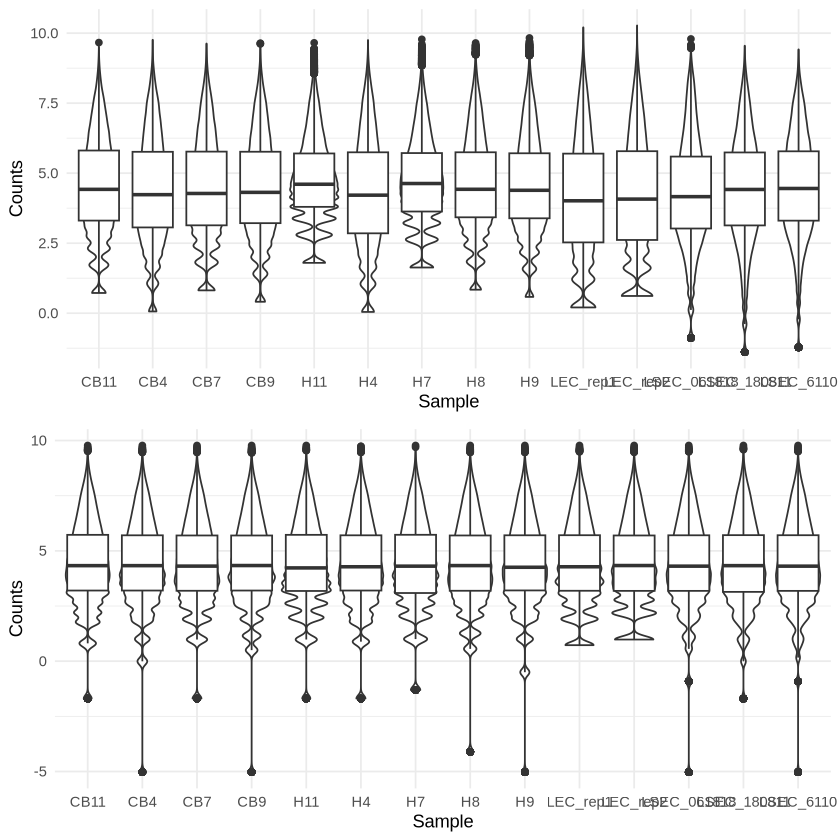

In [7]:
plot1 <- normCounts[,4:ncol(normCounts)] %>% 
	 pivot_longer(., everything(), names_to = "Sample", values_to = "Counts") %>%
	 ggplot(., aes(x=Sample, y = log2(Counts))) + geom_violin() + geom_boxplot() + labs(x = 'Sample', y = 'Counts') +
	 theme_minimal()

# Quantile normalised - limma
plot2 <- normCounts.qn[,4:ncol(normCounts)] %>% 
	 pivot_longer(., everything(), names_to = "Sample", values_to = "Counts") %>%
	 ggplot(., aes(x=Sample, y = log2(Counts))) + geom_violin() + geom_boxplot() + labs(x = 'Sample', y = 'Counts') +
	 theme_minimal()

box_violin <- grid.arrange(plot1,plot2)



In [8]:
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 38380036 & START < 38498477) #ERG Gene Body
ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 38400000 & START < 39440000) #ERG TAD
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 37706576 & START < 39397150) #Extended TAD
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 38397808 & START < 38518355) #Sub TAD
#ERG.counts <- normCounts.qn %>% subset(CHR == 'chr21' & START > 38494247 & START < 39200000) #Foucsed TAD

head(ERG.counts)
ERG.counts %>% dim #to see how many regions have been selected 

,CHR,START,END,LEC_rep1,LEC_rep2,LSEC_061818,LSEC_180811,LSEC_6110,CB4,CB9,CB11,CB7,H8,H4,H9,H7,H11
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
88343,chr21,38401663,38401863,31.70098,37.61740,20.210706,7.971693,33.826958,14.023982,5.532895,7.941000,9.136411,7.420376,26.295811,9.233126,6.143815,14.929161
88344,chr21,38403182,38403382,18.36214,10.89469,11.249436,3.836690,4.385534,3.511143,9.202433,7.941000,7.199121,2.402675,5.881634,3.705017,13.712393,18.735169
88345,chr21,38408169,38408369,41.50643,31.73167,23.282023,29.323795,11.374924,12.693382,3.762990,14.133694,18.362137,20.152733,10.797978,14.371623,19.792983,22.846161
88346,chr21,38410483,38410683,17.07688,24.89297,4.232766,3.836690,5.532895,4.424275,7.971693,3.401731,9.136411,9.136411,10.797978,7.971693,4.125861,6.143815
88347,chr21,38424385,38424585,15.88678,14.27683,7.913720,5.532895,6.116534,6.821608,5.532895,9.202433,18.362137,10.894692,9.202433,4.690445,22.950553,31.118983
88348,chr21,38435338,38435538,26.29581,30.50898,61.220736,38.321023,34.627176,45.069444,53.015359,40.247414,30.181517,44.632902,45.397567,38.786823,37.648088,48.534305


[1] 117  17

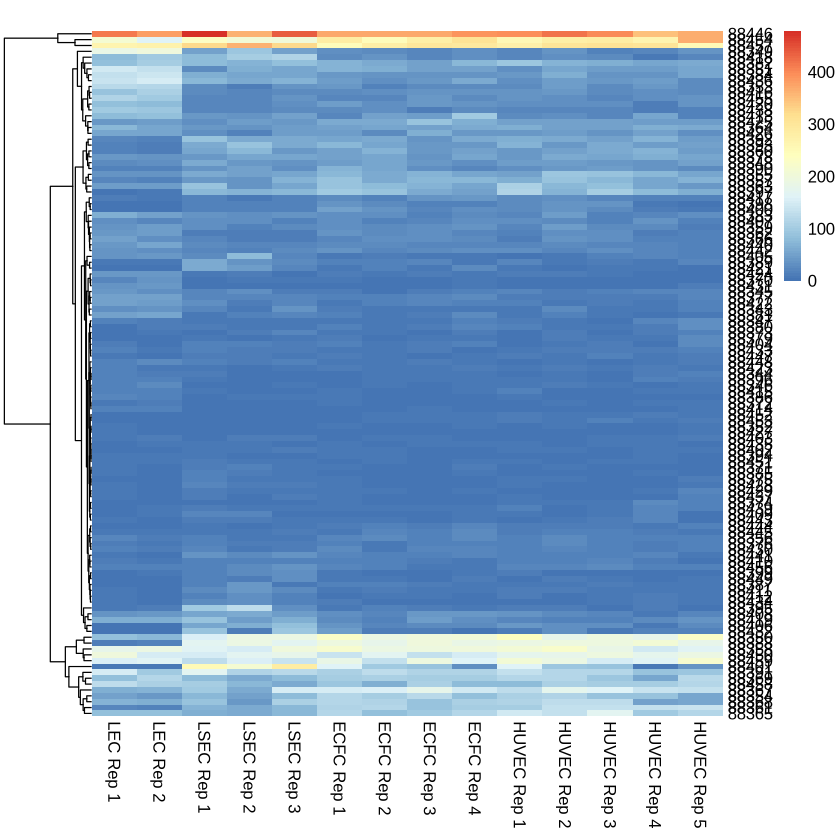

In [23]:
# Plot the heatmap with the NO ROW SCALING to show scalign is needed
new_labels <- c("LEC Rep 1", "LEC Rep 2", "LSEC Rep 1", "LSEC Rep 2", "LSEC Rep 3", "ECFC Rep 1", "ECFC Rep 2", "ECFC Rep 3", "ECFC Rep 4", "HUVEC Rep 1", "HUVEC Rep 2", "HUVEC Rep 3", "HUVEC Rep 4", "HUVEC Rep 5") # Adjust this vector to match the number of columns

heatmap <- pheatmap(ERG.counts[,4:ncol(ERG.counts)], 
	border_color = NA, main = "",
  	show_rownames = TRUE, show_colnames = TRUE, kmeans_k = NA, # 4,
  	cluster_rows = T, cluster_cols = F, labels_col = new_labels)


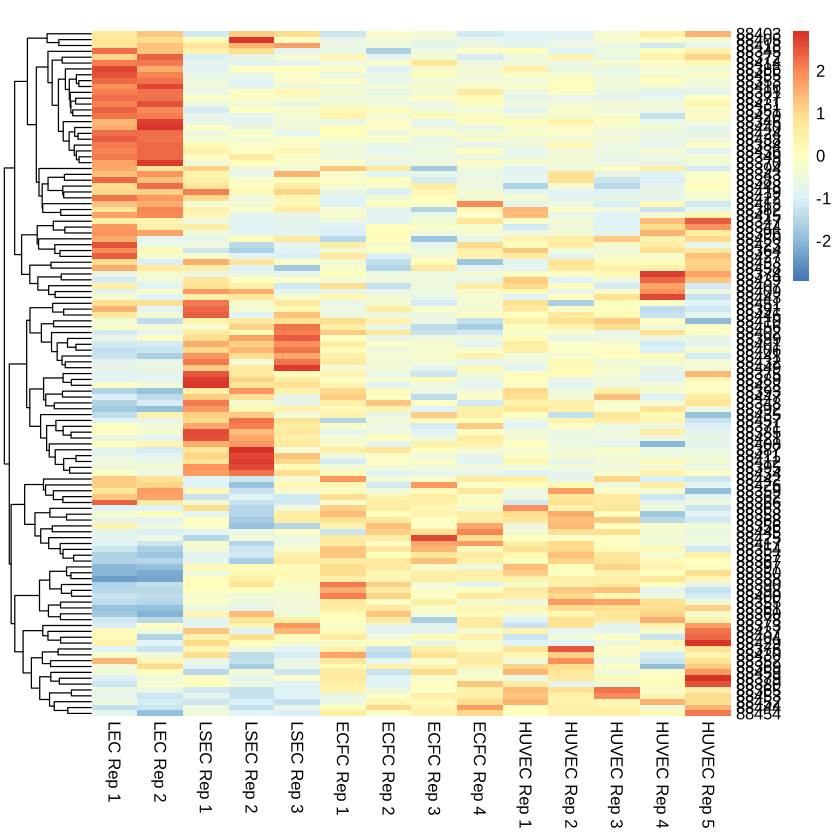

In [41]:
# Plot the heatmap with the new column labels
new_labels <- c("LEC Rep 1", "LEC Rep 2", "LSEC Rep 1", "LSEC Rep 2", "LSEC Rep 3", "ECFC Rep 1", "ECFC Rep 2", "ECFC Rep 3", "ECFC Rep 4", "HUVEC Rep 1", "HUVEC Rep 2", "HUVEC Rep 3", "HUVEC Rep 4", "HUVEC Rep 5") # Adjust this vector to match the number of columns

heatmap <- pheatmap(ERG.counts[,4:ncol(ERG.counts)], 
	border_color = NA, main = "",scale='row',
  	show_rownames = TRUE, show_colnames = TRUE, kmeans_k = NA, # 4,
  	cluster_rows = T, cluster_cols = F, labels_col = new_labels)

In [10]:
# Scale the dataframe by column to see you need row scaling
#first_three_cols <- ERG.counts[, 1:3]
#scaled_columns <- scale(ERG.counts[, 4:ncol(ERG.counts)])
#vals <- bind_cols(first_three_cols, as.data.frame(scaled_columns))


,CHR,START,END,LEC_rep1,LEC_rep2,LSEC_061818,LSEC_180811,LSEC_6110,CB4,CB9,CB11,CB7,H8,H4,H9,H7,H11
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
88343,chr21,38401663,38401863,-0.20380344,-0.08754823,-0.4024583,-0.57009093,-0.1829353,-0.492449200,-0.5772406,-0.52730533,-0.5201345,-0.55103177,-0.287726890,-0.51021923,-0.54379654,-0.4076628
88344,chr21,38403182,38403382,-0.41842541,-0.53972491,-0.5362783,-0.63669591,-0.6217639,-0.658438785,-0.5167613,-0.52730533,-0.5506245,-0.62697608,-0.591351128,-0.59346498,-0.41728311,-0.3488617
88345,chr21,38408169,38408369,-0.04603367,-0.18714097,-0.3565938,-0.22615979,-0.5175860,-0.513458335,-0.6064111,-0.42971902,-0.3749355,-0.35832394,-0.518229339,-0.43284050,-0.31564231,-0.2853487
88346,chr21,38410483,38410683,-0.43910515,-0.30285910,-0.6410594,-0.63669591,-0.6046623,-0.644021139,-0.5370457,-0.59883649,-0.5201345,-0.52505909,-0.518229339,-0.52921469,-0.57752787,-0.5433925
88347,chr21,38424385,38424585,-0.45825398,-0.48249557,-0.5860911,-0.60937411,-0.5959631,-0.606169104,-0.5772406,-0.50742729,-0.3749355,-0.49844701,-0.541960197,-0.57862579,-0.26286159,-0.1575372
88348,chr21,38435338,38435538,-0.29077259,-0.20783022,0.2099510,-0.08123604,-0.1710080,-0.002265364,0.2053380,-0.01821126,-0.1889163,0.01219034,-0.003622569,-0.06518101,-0.01718327,0.1115218


'data.frame':	117 obs. of  17 variables:
 $ CHR        : chr  "chr21" "chr21" "chr21" "chr21" ...
 $ START      : num  38401663 38403182 38408169 38410483 38424385 ...
 $ END        : num  38401863 38403382 38408369 38410683 38424585 ...
 $ LEC_rep1   : num  -0.204 -0.418 -0.046 -0.439 -0.458 ...
 $ LEC_rep2   : num  -0.0875 -0.5397 -0.1871 -0.3029 -0.4825 ...
 $ LSEC_061818: num  -0.402 -0.536 -0.357 -0.641 -0.586 ...
 $ LSEC_180811: num  -0.57 -0.637 -0.226 -0.637 -0.609 ...
 $ LSEC_6110  : num  -0.183 -0.622 -0.518 -0.605 -0.596 ...
 $ CB4        : num  -0.492 -0.658 -0.513 -0.644 -0.606 ...
 $ CB9        : num  -0.577 -0.517 -0.606 -0.537 -0.577 ...
 $ CB11       : num  -0.527 -0.527 -0.43 -0.599 -0.507 ...
 $ CB7        : num  -0.52 -0.551 -0.375 -0.52 -0.375 ...
 $ H8         : num  -0.551 -0.627 -0.358 -0.525 -0.498 ...
 $ H4         : num  -0.288 -0.591 -0.518 -0.518 -0.542 ...
 $ H9         : num  -0.51 -0.593 -0.433 -0.529 -0.579 ...
 $ H7         : num  -0.544 -0.417 -0.316 

In [25]:
# Scale the dataframe by row
vals <- ERG.counts[,1:3] %>% bind_cols(
	t(scale(t(as.matrix(ERG.counts[,4:ncol(ERG.counts)]))))
)

Trying with the kmeans clustering so you can specify the number of clusters:

'data.frame':	117 obs. of  14 variables:
 $ LEC_rep1   : num  1.34 1.809 2.237 1.438 0.498 ...
 $ LEC_rep2   : num  1.863 0.419 1.24 2.745 0.29 ...
 $ LSEC_061818: num  0.322 0.485 0.378 -0.71 -0.533 ...
 $ LSEC_180811: num  -0.761 -0.895 0.994 -0.776 -0.84 ...
 $ LSEC_6110  : num  1.528 -0.793 -0.837 -0.492 -0.765 ...
 $ CB4        : num  -0.225 -0.955 -0.703 -0.678 -0.674 ...
 $ CB9        : num  -0.9772 0.1039 -1.6141 -0.0845 -0.8405 ...
 $ CB11       : num  -0.764 -0.131 -0.556 -0.849 -0.366 ...
 $ CB7        : num  -0.658 -0.269 -0.124 0.11 0.818 ...
 $ H8         : num  -0.8101 -1.1617 0.0584 0.1102 -0.1475 ...
 $ H4         : num  0.861 -0.514 -0.896 0.388 -0.366 ...
 $ H9         : num  -0.6496 -0.9193 -0.5316 -0.0845 -0.9493 ...
 $ H7         : num  -0.9231 0.9433 0.0216 -0.7276 1.4106 ...
 $ H11        : num  -0.145 1.878 0.333 -0.39 2.466 ...


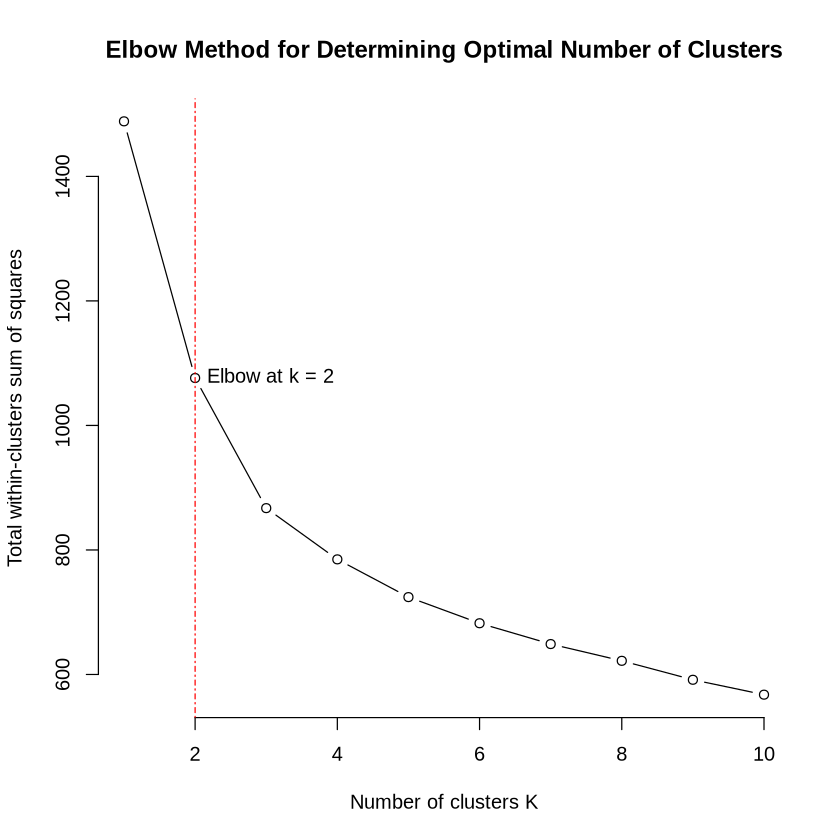

In [28]:

#Find the number of clusters for Kmeans 
vals_numeric <- subset(vals, select = -c(1, 2, 3))
str(vals_numeric)

#Create elbow plot to determine ho wmany clusters to use for Kmeans

wss <- 0

# For 1 to 10 cluster centers
for (i in 1:10) {
  km.out <- kmeans(vals_numeric, centers = i, nstart = 20, iter.max = 50)
   #Save total within sum of squares to wss variable
  wss[i] <- km.out$tot.withinss
}

find_elbow <- function(wss) {
  n <- length(wss)
  x <- 1:n
  # Fit a second-order polynomial (quadratic) to the WSS values
  fit <- lm(wss ~ poly(x, 2, raw = TRUE))
  # The elbow point is where the second derivative is the largest (most negative)
  elbow_point <- which.max(abs(diff(fit$residuals, differences = 2)))
  return(elbow_point+1)  # +1 to adjust for the index offset
}

elbow <- find_elbow(wss)

# Plot the WSS with the elbow point
elbow_plot <- plot(1:10, wss, type = "b", frame = FALSE,
     xlab = "Number of clusters K",
     ylab = "Total within-clusters sum of squares",
     main = "Elbow Method for Determining Optimal Number of Clusters")
abline(v = elbow, col = "red", lty = 4)
text(elbow, wss[elbow], labels = paste("Elbow at k =", elbow), pos = 4)


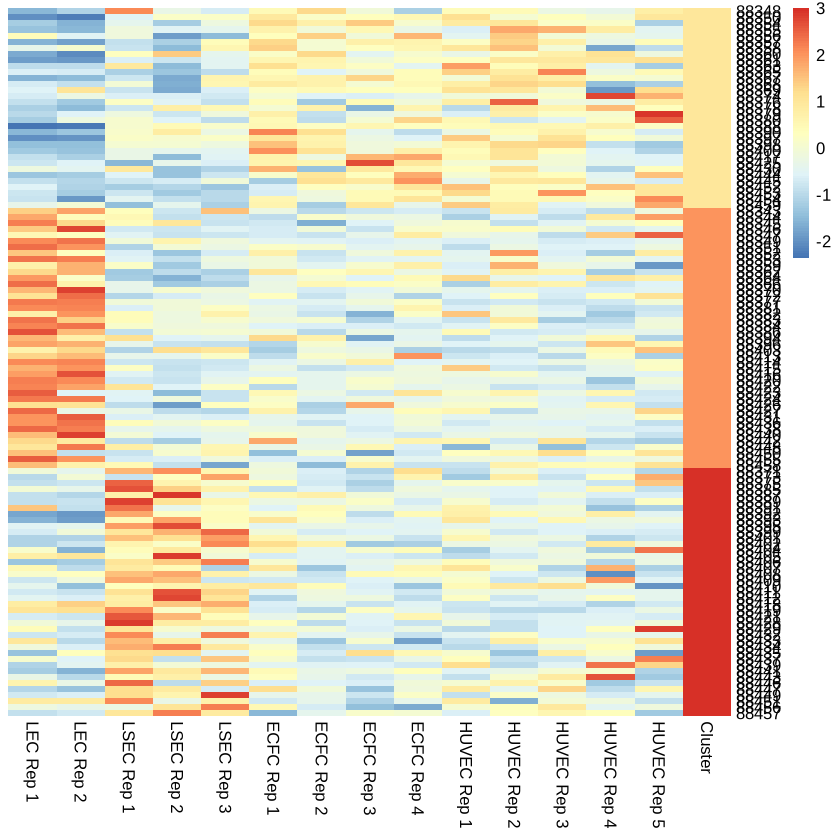

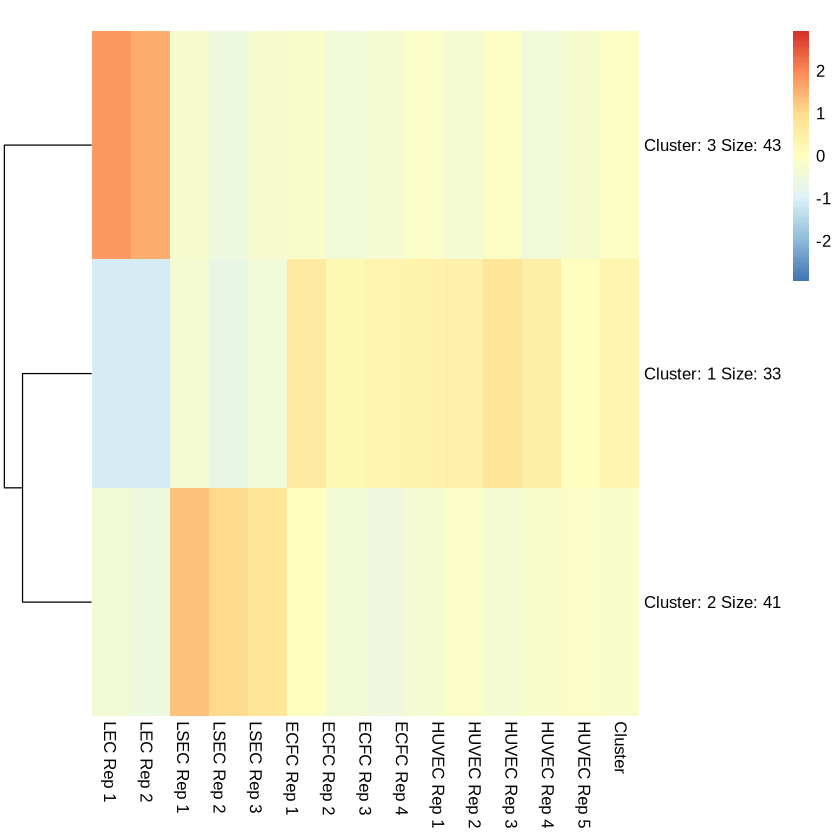

In [50]:
# k = 3
km = kmeans(vals[,4:ncol(vals)], 3) # The last value is the number of clusters. See what the plot looks like with different values
m2 <- cbind(vals,km$cluster)
o <- order(m2[, ncol(m2)])
m2 <- m2[o, ]
new_labels <- c("LEC Rep 1", "LEC Rep 2", "LSEC Rep 1", "LSEC Rep 2", "LSEC Rep 3", "ECFC Rep 1", "ECFC Rep 2", "ECFC Rep 3", "ECFC Rep 4", "HUVEC Rep 1", "HUVEC Rep 2", "HUVEC Rep 3", "HUVEC Rep 4", "HUVEC Rep 5", "Cluster") # Adjust this vector to match the number of columns
#regions <- c("chr21:3843533-38435538", "chr21:38440834-38441034", "chr21:38460308-38460508", "chr21:38470883-38471083", "chr21:38472168-38472368", "chr21:38474156-38474356", "chr21:38476461-38476661", "chr21:38478813-38479013", "chr21:38483871-38484071", "chr21:38486326-38486526", "chr21:38494734-38494934", "chr21:38384148-38384348", "chr21:38388920-38389120", "chr21:38397973-38398173", "chr21:38401663-38401863", "chr21:38403182-38403382", "chr21:38408169-38408369", "chr21:38410483-38410683", "chr21:38424385-38424585", "chr21:38438543-38438743", "chr21:38443139-38443339", "chr21:38448111-38448311", "chr21:38455499-38455699", "chr21:38478093-38478293", "chr21:38484666-38484866", "chr21:38488871-38489071", "chr21:38496317-38496517")
kmeans <- pheatmap(m2[,4:ncol(m2)], border_color = NA, cluster_rows=F,cluster_cols=F,labels_col = new_labels)

#cluster
heatmap <- pheatmap(vals[,4:ncol(vals)], 
	border_color = NA, main = "",scale='row',
  	show_rownames = TRUE, show_colnames = TRUE, kmeans_k = 3, # 4,
  	cluster_rows = T, cluster_cols = F, labels_col = new_labels)




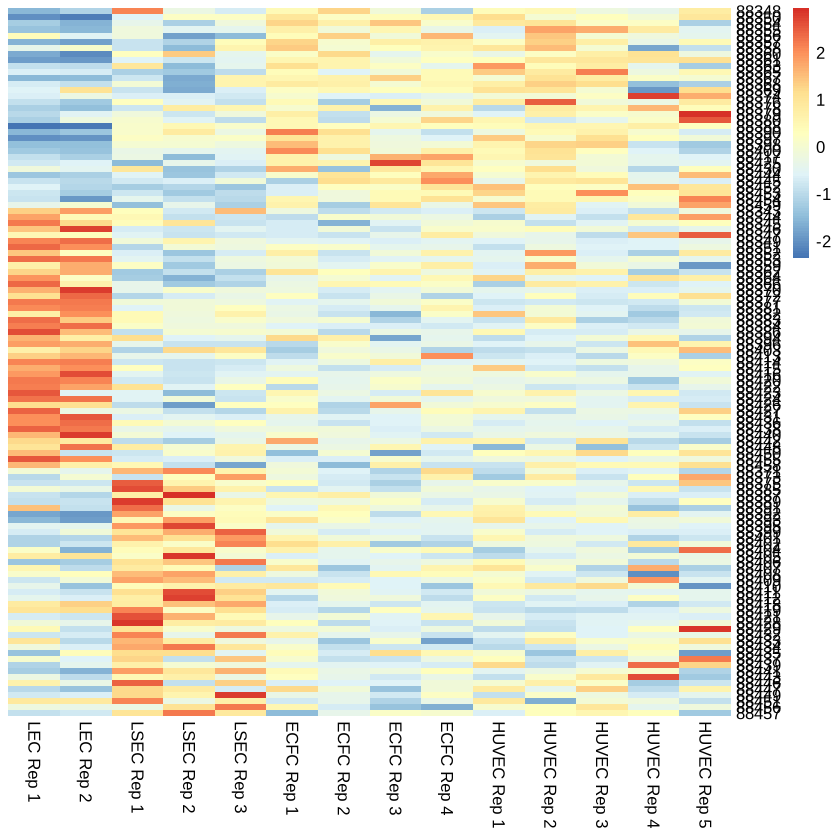

In [51]:
#to remove cluster column 
cluster_column <- km$cluster
cluster_column_index <- which(names(m2) == "km$cluster")
m2_filtered <- m2[, -cluster_column_index]
new_labels <- c("LEC Rep 1", "LEC Rep 2", "LSEC Rep 1", "LSEC Rep 2", "LSEC Rep 3", "ECFC Rep 1", "ECFC Rep 2", "ECFC Rep 3", "ECFC Rep 4", "HUVEC Rep 1", "HUVEC Rep 2", "HUVEC Rep 3", "HUVEC Rep 4", "HUVEC Rep 5") # Adjust this vector to match the number of columns
pheatmap(m2_filtered[, 4:ncol(m2_filtered)], border_color = NA, cluster_rows = FALSE, cluster_cols = FALSE, labels_col = new_labels)


In [57]:
m2 %>% dplyr::select('CHR','START','END',`km$cluster`) %>% subset(`km$cluster` == 3)


,CHR,START,END,km$cluster
,<chr>,<dbl>,<dbl>,<int>
88348,chr21,38435338,38435538,1
88350,chr21,38440834,38441034,1
88354,chr21,38460308,38460508,1
88355,chr21,38470883,38471083,1
88356,chr21,38472168,38472368,1
88357,chr21,38474156,38474356,1
88358,chr21,38476461,38476661,1
88360,chr21,38478813,38479013,1
88361,chr21,38483871,38484071,1
